## 프로젝트
    - 0318 꽃 이미지 분류하기
    - 다양한 Transfer Learning 모델 사용해보기
    
### 라이브러리 및 데이터 불러오기

In [1]:
import tensorflow_datasets as tfds

(raw_train, raw_validation, raw_test), info = tfds.load(
    name = 'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir = '~/aiffel/flowers/',
    download=True,
    with_info=True,
    as_supervised=True,
)

In [2]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


### 이미지 및 라벨 시각화
    1. 시각화
    2. 리사이즈

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

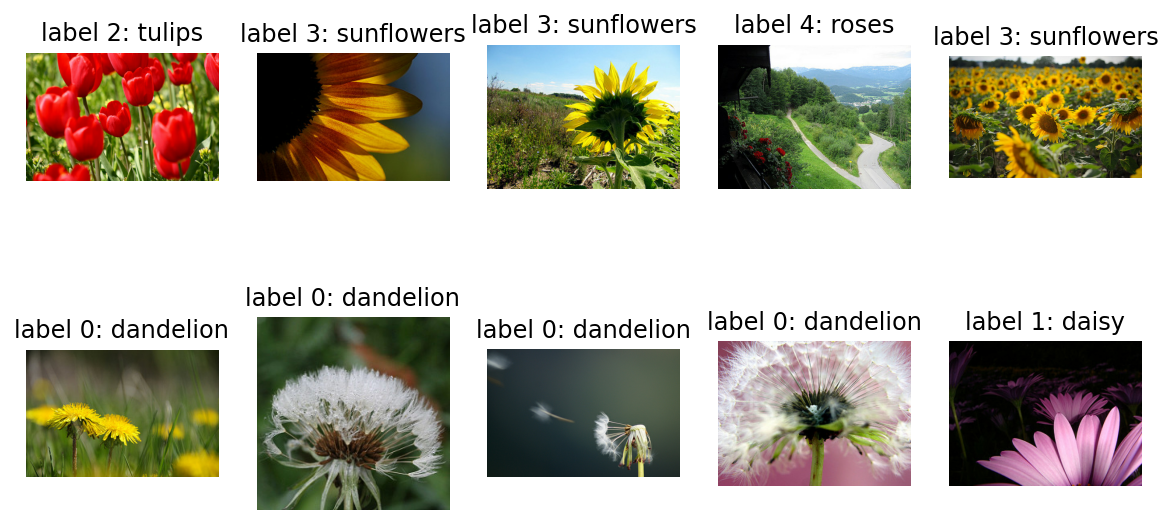

In [4]:
plt.figure(figsize=(10, 5))

get_label_name = info.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [5]:
IMG_SIZE = 224

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = image/255.0
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
#     label = tf.one_hot(label, 5)
    return image, label

In [6]:
train = raw_train.map(format_example)
valid = raw_validation.map(format_example)
test = raw_validation.map(format_example)

print(train)
print(valid)
print(test)

<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>


In [7]:
get_label_name(0)

'dandelion'

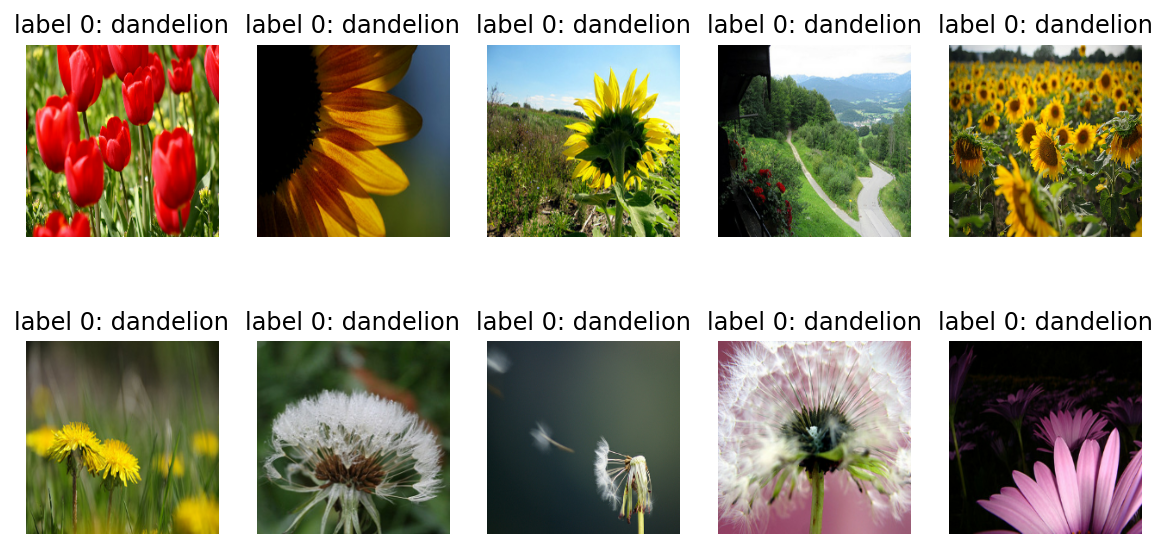

In [8]:
import numpy as np
plt.figure(figsize = (10, 5))

get_label_name = info.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = image
    plt.imshow(image)
    plt.title(f'label {np.argmax(label)}: {get_label_name(np.argmax(label))}')
    plt.axis('off')

### 모델에 넣을 수 있는 형태로 준비하기
    - 이미지를 모두 같은 크기로 formatting 후, train_batchs, valid_batches, test_batches를 준비

In [9]:
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 1000

train_batches = raw_train.map(format_example).repeat().shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
valid_batches = raw_validation.map(format_example).repeat().batch(BATCH_SIZE)
test_batches = raw_test.map(format_example).repeat().batch(BATCH_SIZE)

In [10]:
for image_batch, label_batch in train_batches.take(1):
    break

image_batch.shape, label_batch.shape

(TensorShape([16, 224, 224, 3]), TensorShape([16]))

## 모델 구현 및 검증

### 1. VGG-16

In [11]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [14]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([16, 7, 7, 512])

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [15]:
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 512)


In [16]:
from tensorflow.keras.layers import Dense

dense_layer = Dense(512, activation='relu')
prediction_layer = Dense(5, activation='softmax')

prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

(16, 5)


In [17]:
base_model.trainable = False

In [18]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


In [20]:
learning_rate = 0.0001

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate),
             loss = tf.keras.losses.sparse_categorical_crossentropy,
             metrics = ['accuracy'])

In [21]:
# 데이터셋 크기
train_data_size = len(train)
valid_data_size = len(valid)

# 배치 크기
batch_size = 32

# 한 에폭 당 반복 횟수 계산
steps_per_epoch = train_data_size // batch_size
validation_steps = valid_data_size // batch_size

In [27]:
EPOCHS = 10
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=valid_batches,
                    validation_steps=validation_steps)

Epoch 1/10
91/91 [==============================] - 7s 77ms/step - loss: 0.8252 - accuracy: 0.7308 - val_loss: 0.8138 - val_accuracy: 0.7216
Epoch 2/10
91/91 [==============================] - 7s 78ms/step - loss: 0.7746 - accuracy: 0.7514 - val_loss: 0.7659 - val_accuracy: 0.7216
Epoch 3/10
91/91 [==============================] - 7s 79ms/step - loss: 0.7368 - accuracy: 0.7514 - val_loss: 0.7480 - val_accuracy: 0.7216
Epoch 4/10
91/91 [==============================] - 7s 80ms/step - loss: 0.7279 - accuracy: 0.7685 - val_loss: 0.7261 - val_accuracy: 0.7614
Epoch 5/10
91/91 [==============================] - 7s 80ms/step - loss: 0.6836 - accuracy: 0.7685 - val_loss: 0.6830 - val_accuracy: 0.7443
Epoch 6/10
91/91 [==============================] - 7s 80ms/step - loss: 0.6412 - accuracy: 0.8008 - val_loss: 0.6931 - val_accuracy: 0.7557
Epoch 7/10
91/91 [==============================] - 7s 79ms/step - loss: 0.6547 - accuracy: 0.7891 - val_loss: 0.6555 - val_accuracy: 0.7670
Epoch 8/10
91

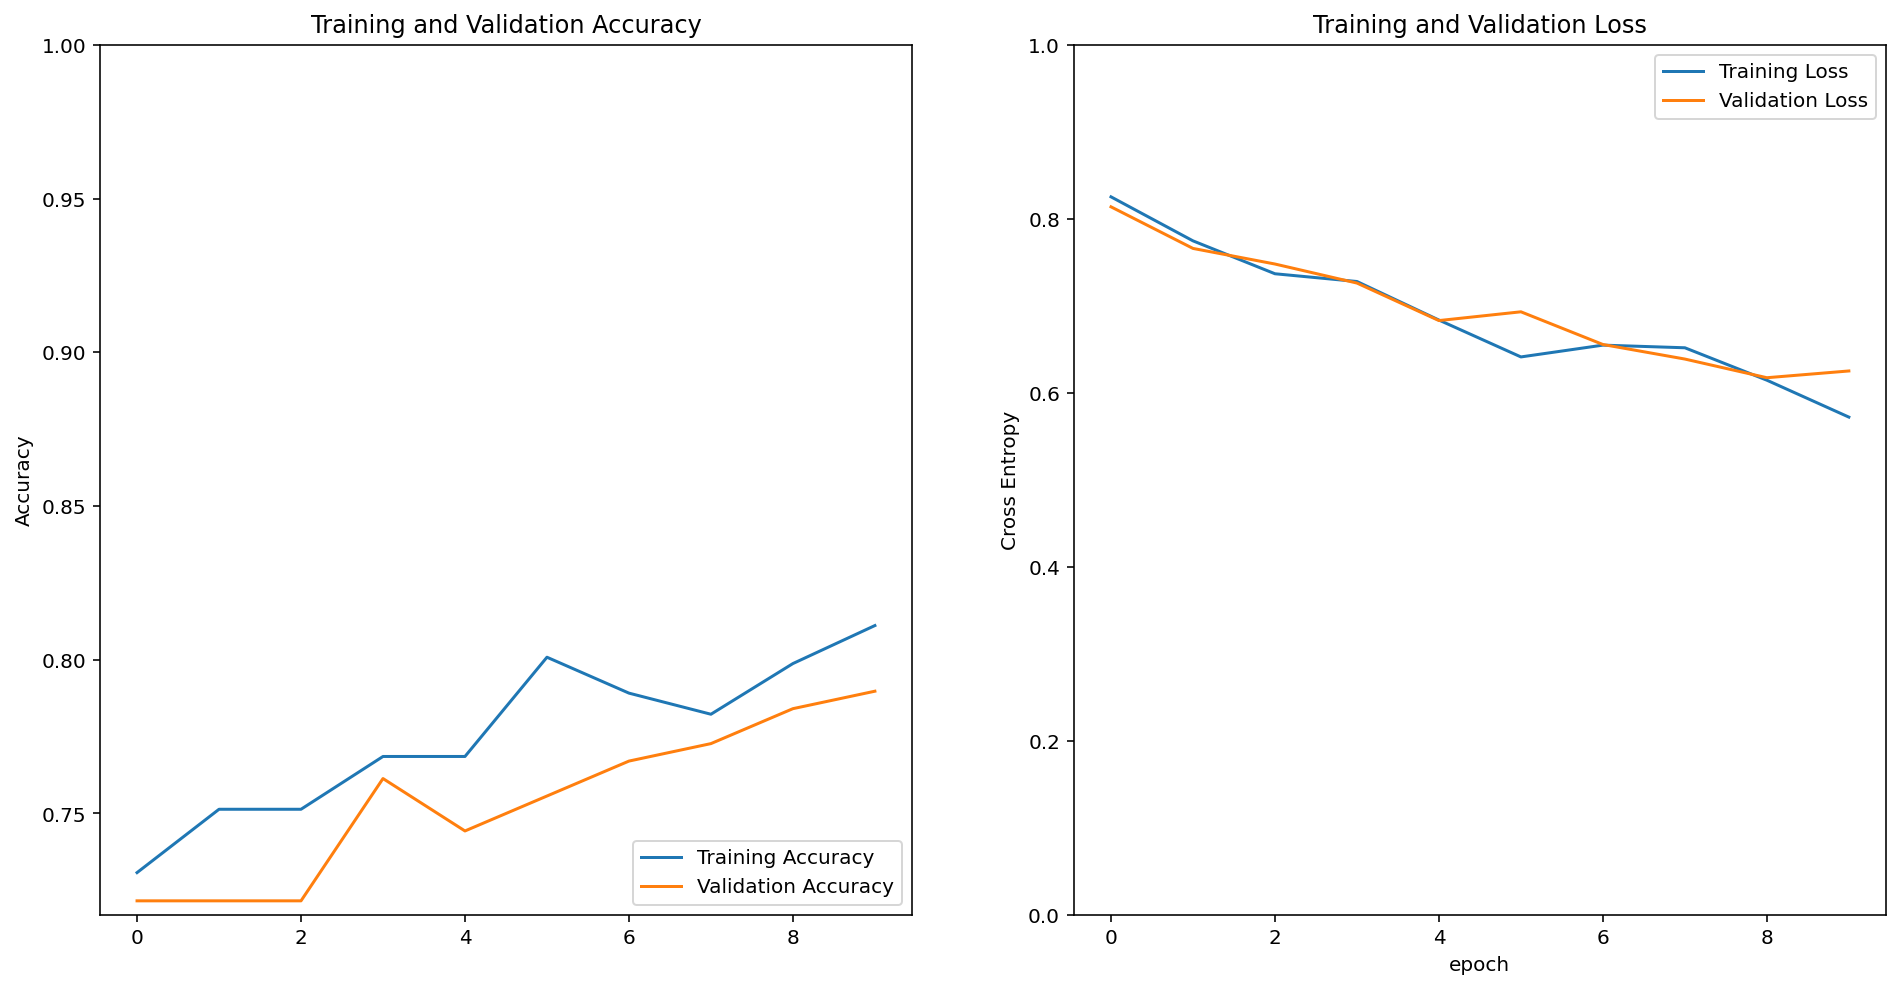

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [29]:
evaluation_results = model.evaluate(test_batches, batch_size=16, steps=steps_per_epoch, return_dict=True)

print("Loss:", evaluation_results['loss'])
print("Accuracy:", evaluation_results['accuracy'])

91/91 [==============================] - 6s 68ms/step - loss: 0.5824 - accuracy: 0.8022
Loss: 0.5823619365692139
Accuracy: 0.8021978139877319


### 2. EfficientNetB1

In [30]:
from tensorflow.keras.applications.efficientnet import EfficientNetB5

In [31]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = EfficientNetB5(input_shape = IMG_SHAPE,
                            include_top = False,
                            weights = 'imagenet')

115277824/115263384 [==============================] - 2s 0us/step


In [32]:
image_batch.shape

TensorShape([16, 224, 224, 3])

In [33]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([16, 7, 7, 2048])

In [34]:
base_model.summary()

Model: "efficientnetb5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [35]:
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 2048)


In [36]:
from tensorflow.keras.layers import Dense

dense_layer_1 = Dense(512, activation='relu')
prediction_layer = Dense(5, activation='softmax')

In [37]:
base_model.trainable = False

In [38]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    dense_layer_1,
    prediction_layer,
])

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb5 (Functional)  (None, 7, 7, 2048)        28513527  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 2565      
Total params: 29,565,180
Trainable params: 1,051,653
Non-trainable params: 28,513,527
_________________________________________________________________


In [40]:
lr = 0.001

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [41]:
validation_steps=20
loss0, accuracy0 = model.evaluate(valid_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 8s 119ms/step - loss: 1.6659 - accuracy: 0.1406
initial loss: 1.67
initial accuracy: 0.14


In [42]:
EPOCHS = 5
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=valid_batches,
                    validation_steps=validation_steps)

Epoch 1/5
91/91 [==============================] - 25s 141ms/step - loss: 1.6807 - accuracy: 0.2067 - val_loss: 1.5678 - val_accuracy: 0.2906
Epoch 2/5
91/91 [==============================] - 13s 141ms/step - loss: 1.6167 - accuracy: 0.2390 - val_loss: 1.5741 - val_accuracy: 0.2469
Epoch 3/5
91/91 [==============================] - 13s 148ms/step - loss: 1.6100 - accuracy: 0.2177 - val_loss: 1.5947 - val_accuracy: 0.2469
Epoch 4/5
91/91 [==============================] - 13s 141ms/step - loss: 1.6042 - accuracy: 0.2473 - val_loss: 1.5811 - val_accuracy: 0.2469
Epoch 5/5
91/91 [==============================] - 13s 144ms/step - loss: 1.6005 - accuracy: 0.2541 - val_loss: 1.5811 - val_accuracy: 0.2469


In [43]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions = np.argmax(predictions, axis=1)
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [44]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = (np.argmax(label) == prediction)
#     print(f"label :{np.argmax(label)} || prediction : {prediction}")
    if correct:
        count = count + 1

print(count / 16 * 100)

100.0


### 3. ResNet50

In [45]:
from tensorflow.keras.applications import ResNet50

In [46]:
base_model = ResNet50(input_shape = IMG_SHAPE,
                     include_top = False,
                     weights = 'imagenet')

94781440/94765736 [==============================] - 1s 0us/step


In [47]:
base_model.trainable = False

In [48]:
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 2048)


In [49]:
from tensorflow.keras.layers import Dropout, BatchNormalization

dense_layer_1 = Dense(1280, activation='relu')
prediction_layer = Dense(5, activation='softmax')

In [50]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    dense_layer_1,
    prediction_layer,
])

In [51]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense_4 (Dense)              (None, 1280)              2622720   
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 6405      
Total params: 26,216,837
Trainable params: 2,629,125
Non-trainable params: 23,587,712
_________________________________________________________________


In [52]:
lr = 0.01

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [53]:
validation_steps=20
loss0, accuracy0 = model.evaluate(valid_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 3s 62ms/step - loss: 2.4158 - accuracy: 0.1813
initial loss: 2.42
initial accuracy: 0.18


In [54]:
EPOCHS = 10
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=valid_batches,
                    validation_steps=validation_steps)

Epoch 1/10
91/91 [==============================] - 10s 69ms/step - loss: 2.8198 - accuracy: 0.2720 - val_loss: 1.5256 - val_accuracy: 0.2906
Epoch 2/10
91/91 [==============================] - 6s 69ms/step - loss: 1.5121 - accuracy: 0.3523 - val_loss: 1.5071 - val_accuracy: 0.3562
Epoch 3/10
91/91 [==============================] - 6s 69ms/step - loss: 1.5224 - accuracy: 0.3324 - val_loss: 1.4720 - val_accuracy: 0.3281
Epoch 4/10
91/91 [==============================] - 6s 70ms/step - loss: 1.5103 - accuracy: 0.3599 - val_loss: 1.5156 - val_accuracy: 0.3594
Epoch 5/10
91/91 [==============================] - 6s 70ms/step - loss: 1.5094 - accuracy: 0.3359 - val_loss: 1.5002 - val_accuracy: 0.4094
Epoch 6/10
91/91 [==============================] - 6s 69ms/step - loss: 1.5010 - accuracy: 0.3468 - val_loss: 1.4703 - val_accuracy: 0.4000
Epoch 7/10
91/91 [==============================] - 6s 70ms/step - loss: 1.4814 - accuracy: 0.3757 - val_loss: 1.4373 - val_accuracy: 0.4031
Epoch 8/10
9

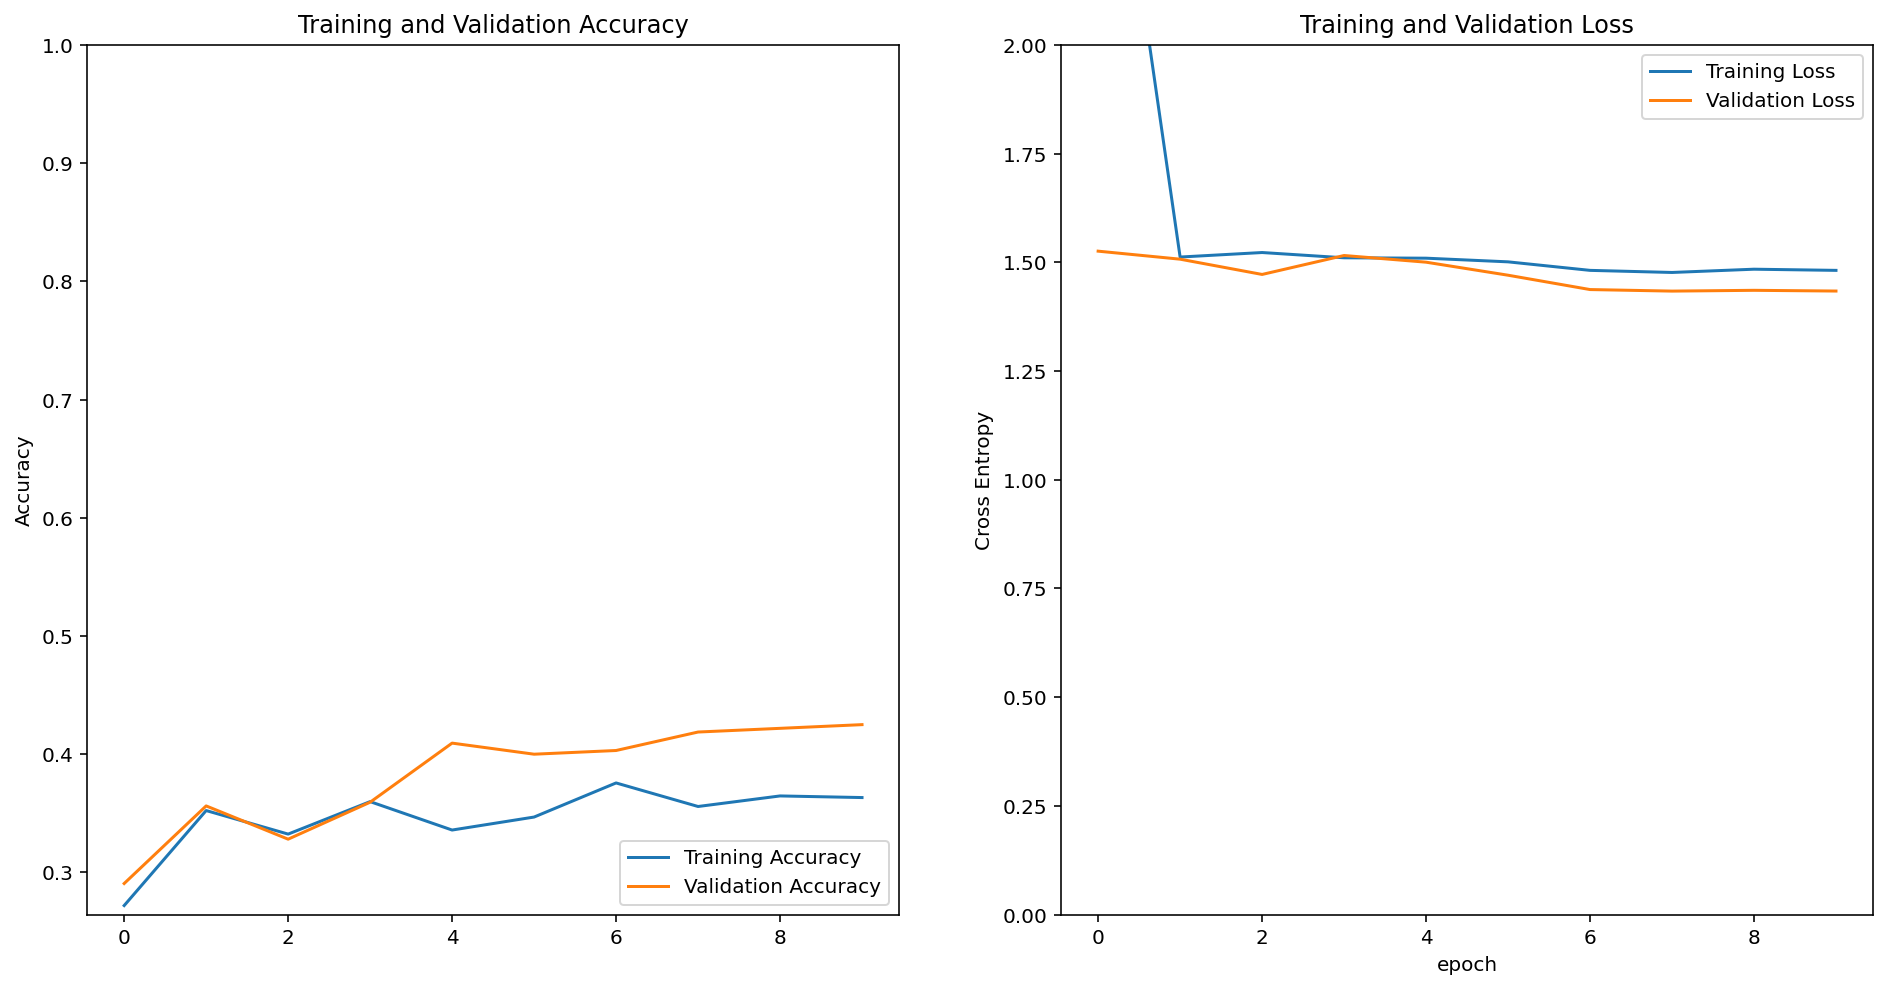

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [56]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

In [57]:
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2])

In [58]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = (np.argmax(label) == prediction)
    if correct:
        count = count + 1

print(count / 16 * 100)

43.75


### 4. MobileNet v2
- MobileNet은 입력 데이터 크기가 224로 지정되어 있기 때문에, 이를 위해 데이터 셋을 한 번 더 받아줍니다.
- 이 후, prediction layer만 만들어서 파인튜닝을 해줍니다.

In [60]:
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
import logging

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [61]:
(training_set, test_set), dataset_info = tfds.load(
 'tf_flowers',
 split=['train[:80%]', 'train[80%:]'],
 with_info=True,
 as_supervised=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /aiffel/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [62]:
IMAGE_RES = 224

def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

train_batches = training_set.shuffle(SHUFFLE_BUFFER_SIZE).map(format_image).repeat().batch(BATCH_SIZE).prefetch(1)
test_batches = test_set.map(format_image).batch(BATCH_SIZE).repeat().prefetch(1)

In [63]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [64]:
feature_extractor.trainable = False

In [65]:
model = tf.keras.Sequential([
    feature_extractor,
    Dense(5, activation='softmax')
])

In [66]:
model.compile(
 optimizer='adam',
 loss=tf.keras.losses.sparse_categorical_crossentropy,
 metrics=['accuracy'])

In [67]:
history = model.fit(train_batches,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch)

Epoch 1/10
91/91 [==============================] - 7s 24ms/step - loss: 0.8820 - accuracy: 0.6593
Epoch 2/10
91/91 [==============================] - 2s 22ms/step - loss: 0.4501 - accuracy: 0.8503
Epoch 3/10
91/91 [==============================] - 2s 21ms/step - loss: 0.3423 - accuracy: 0.8908
Epoch 4/10
91/91 [==============================] - 2s 21ms/step - loss: 0.3196 - accuracy: 0.8977
Epoch 5/10
91/91 [==============================] - 2s 21ms/step - loss: 0.2418 - accuracy: 0.9272
Epoch 6/10
91/91 [==============================] - 2s 21ms/step - loss: 0.2554 - accuracy: 0.9141
Epoch 7/10
91/91 [==============================] - 2s 21ms/step - loss: 0.2233 - accuracy: 0.9320
Epoch 8/10
91/91 [==============================] - 2s 21ms/step - loss: 0.2013 - accuracy: 0.9396
Epoch 9/10
91/91 [==============================] - 2s 21ms/step - loss: 0.1781 - accuracy: 0.9505
Epoch 10/10
91/91 [==============================] - 2s 21ms/step - loss: 0.1768 - accuracy: 0.9485


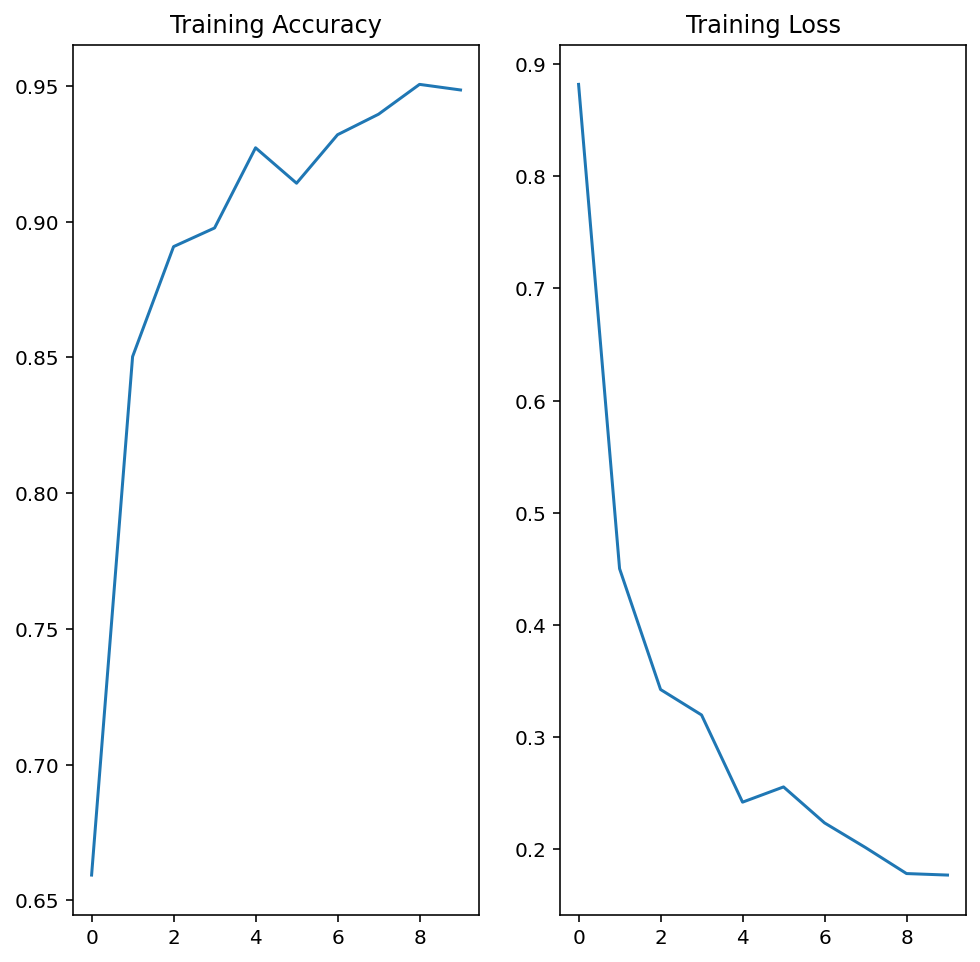

In [68]:
acc = history.history['accuracy']

loss = history.history['loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.title('Training Loss')
plt.show()

In [69]:
evaluation_results = model.evaluate(test_batches, batch_size=16, steps=steps_per_epoch, return_dict=True)

print("Loss:", evaluation_results['loss'])
print("Accuracy:", evaluation_results['accuracy'])

91/91 [==============================] - 3s 25ms/step - loss: 0.2589 - accuracy: 0.9051
Loss: 0.2589223384857178
Accuracy: 0.9050894379615784


- Validation 코드를 넣으면 계속 오류가 발생해서 train, test를 8 : 2로 나누어서 데이터를 분리하였습니다.

### 5. 일반 모델
- 모델은 이전 프로젝트에서 직접 만들어보았던 dual_net을 기반으로 작성하였습니다.

In [70]:
def dual_net(input_shape=(224, 224, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Dual 1
    x1 = tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(inputs)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
    x1 = tf.keras.layers.Conv2D(128, (5, 5), strides=1, activation='relu', padding='same')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)

    # Dual 2
    x2 = tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(inputs)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.MaxPooling2D((2, 2))(x2)
    x2 = tf.keras.layers.Conv2D(128, (5, 5), strides=1, activation='relu', padding='same')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.GlobalAveragePooling2D()(x2)

    # Concatenation
    x = tf.keras.layers.Concatenate()([x1, x2])

    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="DualNet")
    return model

# 모델 요약 출력
model = dual_net()
model.summary()

Model: "DualNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 224, 224, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 64) 256         conv2d[0][0]                     
____________________________________________________________________________________________

In [71]:
model.compile(
 optimizer='adam',
 loss=tf.keras.losses.sparse_categorical_crossentropy,
 metrics=['accuracy'])

In [72]:
EPOCHS = 20

history = model.fit(train_batches,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch)

Epoch 1/20
91/91 [==============================] - 28s 218ms/step - loss: 1.6138 - accuracy: 0.3963
Epoch 2/20
91/91 [==============================] - 20s 215ms/step - loss: 1.3577 - accuracy: 0.4636
Epoch 3/20
91/91 [==============================] - 19s 214ms/step - loss: 1.2719 - accuracy: 0.4856
Epoch 4/20
91/91 [==============================] - 19s 214ms/step - loss: 1.2276 - accuracy: 0.5000
Epoch 5/20
91/91 [==============================] - 20s 215ms/step - loss: 1.2119 - accuracy: 0.5069
Epoch 6/20
91/91 [==============================] - 20s 215ms/step - loss: 1.1231 - accuracy: 0.5275
Epoch 7/20
91/91 [==============================] - 20s 214ms/step - loss: 1.1974 - accuracy: 0.5405
Epoch 8/20
91/91 [==============================] - 19s 214ms/step - loss: 1.1025 - accuracy: 0.5598
Epoch 9/20
91/91 [==============================] - 19s 214ms/step - loss: 1.1031 - accuracy: 0.5701
Epoch 10/20
91/91 [==============================] - 19s 214ms/step - loss: 1.0660 - accura

In [73]:
evaluation_results = model.evaluate(test_batches, batch_size=16, steps=steps_per_epoch, return_dict=True)

print("Loss:", evaluation_results['loss'])
print("Accuracy:", evaluation_results['accuracy'])

91/91 [==============================] - 7s 75ms/step - loss: 1.1223 - accuracy: 0.5867
Loss: 1.1222995519638062
Accuracy: 0.5866575241088867


## 회고

-  최대한 다양한 모델을 비교해보고 싶었는데, tfds 라이브러리로 불러온 이미지 데이터를 다루는 방법을 잘 몰라서 제대로 적용해보지 못했다.
- 본 프로젝트를 진행하면서 dataset이 batch_size로 확인하면 부족하기에, repeat 함수를 호출하라는 경고와 함께 계속 학습이 중단되는 문제가 있었다.
- 따라서 이를 해결하고자 모든 dataset에 repeat함수를 적용하고 fit 함수에서 steps_per_epoch을 주어서 이를 해결했다.
- 또한 생각했던 것과 달리 EfficientNet과 ResNet이 되게 처참한 점수를 보여주었다.
- 모델들 성능은 MobileNetv2 > VGG 16 > DualNet > ResNet50 > EfficientNetB5 순으로 높은 정확도를 보여주었다.


- 성능을 개선하고자 다양한 것들을 시도해보고자 했으나, 지식이 부족해 잘 해내지 못해서 아쉬운 것 같다.
- 앞으로 더 공부해서 부족한 부분을 채워야겠다.